In [3]:
from utils import *
from pyBDSF_to_COCO import *
import matplotlib

In [17]:
!python pyBDSF_to_COCO.py --image ../data/MIGHTEE/early_science/MIGHTEE_Continuum_Early_Science_COSMOS_r0p0.app.restored.circ.fits \
--catalog ../data/MIGHTEE/early_science/MIGHTEE_Continuum_Early_Science_COSMOS_Level1.txt \
--output_file ../data/MIGHTEE/early_science/cosmos_coco_annotations.json \
--dataset_year 2020 \
--description "MIGHTEE COSMOS field" \
--dataset_url https://www.mighteesurvey.org/data-access \
--category_names source \
--keymap ../data/MIGHTEE/early_science/mightee_keymap.json

[{'id': 0, 'file_name': '../data/MIGHTEE/early_science/MIGHTEE_Continuum_Early_Science_COSMOS_r0p0.app.restored.circ.fits', 'width': 5450, 'height': 5450, 'date_captured': '2023-05-17T11:33:30.777', 'license': 1, 'coco_url': '', 'flickr_url': ''}]
9896


In [1]:
import json
with open("../data/MIGHTEE/early_science/cosmos_coco_annotations.json") as f:
    ccat = json.load(f)

In [2]:
df = pd.DataFrame(ccat['annotations'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9895 entries, 0 to 9894
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            9895 non-null   int64 
 1   image_id      9895 non-null   int64 
 2   category_id   9895 non-null   int64 
 3   iscrowd       9895 non-null   int64 
 4   area          9895 non-null   int64 
 5   bbox          9895 non-null   object
 6   segmentation  9895 non-null   object
dtypes: int64(5), object(2)
memory usage: 541.3+ KB


In [23]:
df.head()

,id,image_id,category_id,iscrowd,area,bbox,segmentation
0,0,0,1,0,90,"[382, 2767, 10, 9]","[[382.15992161653594, 2772.6741570091704, 382...."
1,1,0,1,0,64,"[394, 2854, 8, 8]","[[394.4649201913345, 2858.5612522108104, 394.4..."
2,2,0,1,0,72,"[406, 2593, 9, 8]","[[406.83836061815606, 2599.4379812593784, 406...."
3,3,0,1,0,72,"[416, 2927, 9, 8]","[[416.3920480976015, 2930.8887014072698, 416.3..."
4,4,0,1,0,64,"[422, 3153, 8, 8]","[[429.7611397222382, 3158.241001647481, 429.51..."


In [3]:
### check new overlap code

In [17]:
exec(open("utils.py").read())

In [6]:
boxes = df.bbox.values
segs = df.segmentation.values

In [102]:
#reformat segmentations into [[x],[y]]
new_segs = []
for s in segs:
    sx = s[0][0::2]
    sy = s[0][1::2]
    new_segs.append([sx,sy])

In [14]:
boxes[0], type(boxes), boxes.shape

([382, 2767, 10, 9], numpy.ndarray, (9895,))

In [24]:
cx,cy = get_bbox_center(boxes[0])
cx, cy, cx - 50/2, cy - 50/2

(386.5, 2772.0, 361.5, 2747.0)

In [25]:
boxx = np.array([b[0] for b in boxes])
np.min(boxx)

382

In [36]:
boxy = np.array([b[1] for b in boxes])
np.min(boxy), np.max(boxy)

(388, 5065)

In [72]:
def sources_within_extent(boxes, cx, cy, extent=150):
    """return indices of boxes that exist within a given extent x extent area"""
    boxx = np.array([b[0] for b in boxes]) #sort by x lower
    boxy = np.array([b[1] for b in boxes])
    #source_indices = []
    xin = np.intersect1d(np.where(boxx > cx - extent/2), np.where(boxx < cx + extent/2))
    yin = np.intersect1d(np.where(boxy > cy - extent/2), np.where(boxy < cy + extent/2))
    source_indices = np.intersect1d(xin,yin)   
    return list(source_indices)

In [118]:
def check_overlap(bboxes, segs):
    """check if any segmentations in a single crop/image overlap"""
    iscrowd = np.zeros(len(segs)).astype(int)
    #use shapely Polygon
    #polygons = [Polygon(np.array(s).T) for s in segs] #replace .T

    for i,(b,s) in enumerate(zip(bboxes, segs)):
        #get sources within extent of b
        cx,cy = get_bbox_center(b)
        source_indices = sources_within_extent(bboxes,cx,cy)
        source_indices.remove(i) #that's the input box

        subsegs = segs[source_indices]
        p = Polygon(np.array(s).T)
        polygons = [Polygon(np.array(s).T) for s in subsegs] #these should just be the ones close to the box 
        inter = [j for j,p2 in enumerate(polygons) if i !=j and p.intersects(p2)]
        if inter != []:
            for k in inter:
                #smallcat.append({"image_id":n,"bbox":jdf.bbox[k],"segmentation":jdf.segmentation[k]})
                iscrowd[k] = 1
        if i==1000:
            break
    return iscrowd.tolist()

In [119]:
%%time
iscrowd = check_overlap(boxes, np.array(new_segs))

CPU times: user 4.5 s, sys: 0 ns, total: 4.5 s
Wall time: 4.88 s


In [120]:
len(iscrowd), sum(iscrowd)

(9895, 18)

In [84]:
source_indices = sources_within_extent(boxes, cx,cy)
source_indices 

[0, 6, 12]

In [85]:
source_indices.remove(0)

In [86]:
source_indices

[6, 12]

In [77]:
import matplotlib.patches as patches

In [59]:
patches.Rectangle(boxes[0][:2],*boxes[0][2:])

(2600.0, 2900.0)

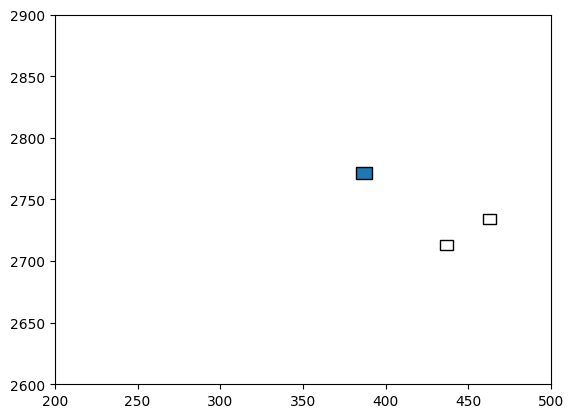

In [70]:
fig, ax = plt.subplots()
ax.add_patch(patches.Rectangle(boxes[0][:2],*boxes[0][2:]))
for i in source_indices:
    rect = patches.Rectangle(boxes[i][:2], *boxes[i][2:], edgecolor='k', facecolor='none')
    ax.add_patch(rect)
ax.set_xlim([200,500])
ax.set_ylim([2600, 2900])

## MIGHTEE COSMOS crop catalogs -> COCO

In [263]:
!python pyBDSF_to_COCO.py --image ../data/MIGHTEE/early_science/MIGHTEE_Continuum_Early_Science_COSMOS_r0p0.app.restored.circ.fits \
--catalog ../data/MIGHTEE/early_science/MIGHTEE_Continuum_Early_Science_COSMOS_Level1.txt \
--crop_coords ../data/MIGHTEE/early_science/MIGHTEE_Continuum_Early_Science_COSMOS_r0p0.app.restored.circ_crop_coords.npy \
--crop_prefix arrays/adapteq/COSMOS_r0p0_log10_adapteq_ \
--output_file ../data/MIGHTEE/early_science/cosmos_crop_coco_annotatons.json \
--description "MIGHTEE COSMOS field" \
--dataset_url https://www.mighteesurvey.org/data-access \
--category_names source 

In [311]:
import json
with open("../data/MIGHTEE/early_science/cosmos_crop_coco_annotatons.json") as f:
    ccat = json.load(f)

In [312]:
len(ccat['images']), len(ccat['annotations'])

(421, 15745)

In [124]:
ccat["info"]

{'year': 2023,
 'version': '',
 'description': 'MIGHTEE COSMOS field',
 'contributer': 'glados',
 'url': 'https://www.mighteesurvey.org/data-access',
 'date_created': '2023-05-01T11:36:41.484'}

In [41]:
ccat["categories"]

[{'id': 1, 'name': 'source', 'supercategory': ''}]

In [181]:
ccat["images"][5]

{'id': 5,
 'file_name': '../data/MIGHTEE/early_science/arrays/adapteq/COSMOS_r0p0_log10_adapteq_crop_5.npy',
 'width': 256,
 'height': 256,
 'date_captured': '2023-05-01T11:50:08.966',
 'license': 1,
 'coco_url': '',
 'flickr_url': ''}

In [193]:
cdf = pd.DataFrame(ccat["annotations"])
cdf.describe()

,id,image_id,category_id,iscrowd,area
count,51.000000,51.000000,51.0,51.000000,51.000000
mean,25.000000,3.529412,1.0,0.039216,94.490196
std,14.866069,1.879925,0.0,0.196039,38.136792
min,0.000000,0.000000,1.0,0.000000,56.000000
25%,12.500000,2.000000,1.0,0.000000,72.000000
50%,25.000000,4.000000,1.0,0.000000,81.000000
75%,37.500000,5.000000,1.0,0.000000,100.000000
max,50.000000,6.000000,1.0,1.000000,256.000000


In [194]:
cdf.segmentation[0]

[[38.50043478371134, 174.2051183979056],
 [37.91256960716106, 173.38776482672938]]

In [70]:
def plot_image_catalog(image, annotations_json, bounding_boxes = True, segmentations = False, crop_number = None, **kwargs):
    """Plot the image and the associated bounding boxes and/or segmentations on top for verification"""
    try:
        wcs ,_, dat = mapdata_from_fits(image)
    except OSError:
        if isinstance(image,dict): #it's the json
            dat = np.load(image['file_name'])
            crop_number = image['id']
        else:
            dat = np.load(image)
            if not crop_number:
                crop_number = int(image[image.rfind("_")+1:image.rfind(".")])
    if isinstance(annotations_json, list): #it's already the dict item
        jdf = pd.DataFrame(annotations_json)
        jdf = jdf.where(jdf.image_id == crop_number).dropna(how='all')
    elif isinstance(annotations_json, pd.DataFrame):
        jdf = annotations_json
        jdf = jdf.where(jdf.image_id == crop_number).dropna(how='all')
    else:
        with open(annotations_json) as f:
            data = json.load(f)
        jdf = pd.DataFrame(data[1:]) #[0] is image annotations

    if bounding_boxes:
        bboxes = jdf.bbox
    if segmentations:
        segs = jdf.segmentation

    fig,ax = plt.subplots() #should this be plotted in wcs? can it?
    ax.imshow(dat, **kwargs)
    if bounding_boxes:
        for box in bboxes:
            #draw rectangle
            rect = patches.Rectangle((box[0],box[1]),box[2],box[3], edgecolor='w', facecolor='none')
            ax.add_patch(rect)
    if segmentations:
        for seg in segs:
            #draw ellipse
            ax.plot(seg[0],seg[1],'r')    

    return fig

../data/MIGHTEE/early_science/arrays/adapteq/COSMOS_r0p0_log10_adapteq_crop_230.npy


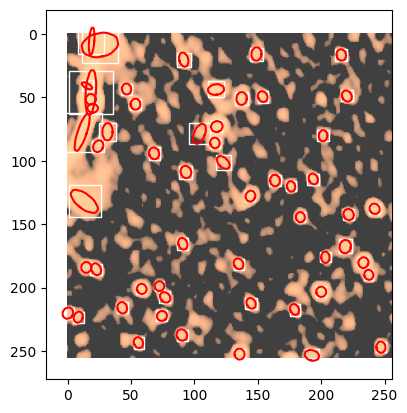

In [75]:
#n = np.random.randint(421)
print(ccat["images"][n]['file_name'])
fig = plot_image_catalog(ccat["images"][n], ccat["annotations"], segmentations = True, alpha = 0.75, cmap=matplotlib.colormaps["copper"])
#fig = plot_image_catalog(f"../data/MIGHTEE/early_science/arrays/adapteq/COSMOS_r0p0_log10_adapteq_crop_{n}.npy", ccat["annotations"], bounding_boxes = False, segmentations = True)

In [79]:
from shapely.geometry import Polygon

In [101]:
jdf = pd.DataFrame(ccat["annotations"])
jdf = jdf.where(jdf.image_id == 230).dropna(how='all').reset_index(drop=True)

In [129]:
polygons = []
for i, row in jdf.iterrows():
    coords = np.array(row.segmentation)
    poly = Polygon(coords.T)
    polygons.append(poly)

In [133]:
smallcat = [] #{"image_id":[],"bbox":[],"segmentation":[]}
for i,p in enumerate(polygons):
    inter = [j for j,p2 in enumerate(polygons) if i !=j and p.intersects(p2)]
    if inter != []:
        for k in inter:
            smallcat.append({"image_id":n,"bbox":jdf.bbox[k],"segmentation":jdf.segmentation[k]})

In [138]:
def check_overlap(segs):
    """check if any segmentations in a single crop/image overlap"""
    iscrowd = np.zeros(len(segs)).astype(int)
    #use shapely Polygon
    polygons = [Polygon(np.array(s).T) for s in segs]

    for i,p in enumerate(polygons):
        inter = [j for j,p2 in enumerate(polygons) if i !=j and p.intersects(p2)]
        if inter != []:
            for k in inter:
                #smallcat.append({"image_id":n,"bbox":jdf.bbox[k],"segmentation":jdf.segmentation[k]})
                iscrowd[k] = 1
    return iscrowd

In [139]:
iscrowd = check_overlap(jdf.segmentation)

In [148]:
jdf["iscrowd"] = iscrowd

In [151]:
smallcat = jdf.where(jdf.iscrowd ==1).dropna(how='all')
smallcat

,id,image_id,category_id,iscrowd,area,bbox,segmentation
0,8778.0,230.0,1.0,1.0,72.0,"[14, 47, 8, 9]","[[22.096386362995872, 22.05247949598106, 21.60..."
1,8779.0,230.0,1.0,1.0,841.0,"[11, -6, 29, 29]","[[27.433886945977974, 23.745120675743692, 20.0..."
2,8780.0,230.0,1.0,1.0,961.0,"[-4, 62, 31, 31]","[[14.824255430063658, 13.559681397518943, 11.9..."
3,8781.0,230.0,1.0,1.0,1190.0,"[1, 29, 35, 34]","[[22.23616306038184, 21.897913311902812, 21.15..."
4,8782.0,230.0,1.0,1.0,72.0,"[16, 54, 8, 9]","[[19.76018229840429, 18.67537339153705, 17.639..."
5,8783.0,230.0,1.0,1.0,441.0,"[8, -5, 21, 21]","[[20.98169416505516, 20.776964164454967, 20.36..."
6,8784.0,230.0,1.0,1.0,81.0,"[11, 36, 9, 9]","[[14.3463031429701, 13.31113153153774, 12.4146..."


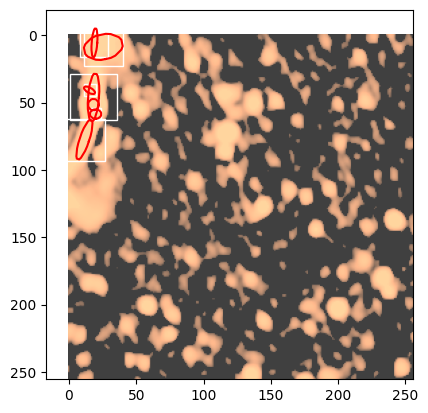

In [157]:
fig = plot_image_catalog(ccat["images"][n], smallcat, segmentations = True, alpha = 0.75, cmap=matplotlib.colormaps["copper"])

In [ ]:
def overlap2(rect1,rect2):
    p1 = Polygon([(rect1[0],rect1[1]), (rect1[1],rect1[1]),(rect1[2],rect1[3]),(rect1[2],rect1[1])])
    p2 = Polygon([(rect2[0],rect2[1]), (rect2[1],rect2[1]),(rect2[2],rect2[3]),(rect2[2],rect2[1])])
    return(p1.intersects(p2))

print(overlap2(rect1,rect2))

## MGCLS large crops -> COCO

In [2]:
cc =read_catalog("../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_compact_source_catalog.csv")
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7040 entries, 0 to 7039
Data columns (total 14 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  7040 non-null   int64  
 1   (# Source_name, Unnamed: 1_level_1)       7040 non-null   object 
 2   (RA, DEG)                                 7040 non-null   float64
 3   (DEC, DEG)                                7040 non-null   float64
 4   (DeltaRA_deg, DEG)                        7040 non-null   float64
 5   (DeltaDec_deg, DEG)                       7040 non-null   float64
 6   (Stot_mJy, mJy)                           7040 non-null   float64
 7   (DeltaStot_mJy, mJy)                      7040 non-null   float64
 8   (Ipk_mJyb, mJyb)                          7040 non-null   float64
 9   (DeltaIpk_mJyb, mJyb)                     7040 non-null   float64
 10  (Maj, DEG)                          

In [ ]:
--crop_coords ../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_large_coords.npy \
--crop_prefix J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_ \

In [50]:
!python pyBDSF_to_COCO.py --image ../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor.fits \
--catalog ../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_compact_source_catalog.csv \
--output_file ../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_teste_annotatons.json \
--category_names source \
--test True

In [33]:
with open("../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_teste_annotatons.json") as f:
    mgcat = json.load(f)

In [36]:
def plot_image_catalog(image, annotations_json,crop_number = 0, bounding_boxes = True, segmentations = False, **kwargs):
    """Plot the image and the associated bounding boxes and/or segmentations on top for verification"""
    # try:
    #     wcs, dat = mapdata_from_fits(image)
    #     dat = dat.squeeze()
    # except OSError:
    #     dat = np.load(image)
    #     crop_number = int(image[image.rfind("_")+1:image.rfind(".")])
    dat = image
    if isinstance(annotations_json, list): #it's already the dict item
        jdf = pd.DataFrame(annotations_json)
        try:
            jdf = jdf.where(jdf.image_id == crop_number).dropna(how='all')
        except UnboundLocalError:
            pass
    else:
        with open(annotations_json) as f:
            data = json.load(f)
        jdf = pd.DataFrame(data["annotations"]) #[0] is image annotations
    jdf = jdf.where(jdf.image_id == crop_number).dropna(how='all')
    if bounding_boxes:
        bboxes = jdf.bbox
        #print(bboxes)
    if segmentations:
        segs = jdf.segmentation

    fig,ax = plt.subplots() #should this be plotted in wcs? can it?
    ax.imshow(dat, **kwargs)
    if bounding_boxes:
        for box in bboxes:
            #draw rectangle
            rect = patches.Rectangle((box[0],box[1]),box[2],box[3], edgecolor='w', facecolor='none')
            ax.add_patch(rect)
    if segmentations:
        for seg in segs:
            #draw ellipse
            if len(seg) == 1:
                segx = [x for i,x in enumerate(seg[0])if i%2 == 0]
                segy = [x for i,x in enumerate(seg[0])if i%2 == 1]
            else: 
                segx = seg[0]
                segy = seg[1]
            ax.plot(segx,segy,'r')    

    return fig


In [57]:
with fits.open("../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor.fits") as f:
    aa = f[0].data.squeeze()
arr = aa[0]
arr.shape

(3457, 3457)

In [37]:
%matplotlib widget

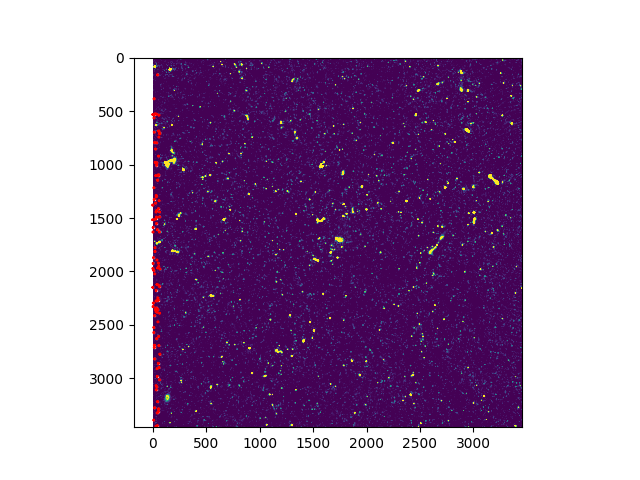

In [59]:
fig = plot_image_catalog(arr,"../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_teste_annotatons.json", segmentations=True, vmin=1e-9,vmax=1e-4)

In [2]:
exec(open("utils.py").read())

In [2]:
catalog = "../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_compact_source_catalog.csv"
image = "../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor.fits"
crop_coords = "../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_large_coords.npy"
df = read_catalog(catalog)
keydict = None
rakey, deckey, majkey, minkey, pakey = keys_used(keydict)
keylist = [rakey, deckey, majkey, minkey, pakey]
wcs, _ = mapdata_from_fits(image)
df = df.sample(n=200).reset_index(drop=True) #for now
df = catalog_coords_to_pix(df, wcs, keylist)

In [3]:
if np.isnan(df[rakey].DEG[0]):
    df.drop(0, inplace = True)
df.reset_index(inplace=True, drop=True)

In [4]:
image_info=[]
coordlist = np.load(crop_coords, allow_pickle=True) #numpy array
crop_shape = get_crop_shape(coordlist[0], wcs)
crop_shape

(1280, 1280)

In [52]:
pixvals_from_Skycoord(wcs,coordlist[1][0][0], coordlist[1][1][0])

(1088, 0, 2368, 1280, 1280, 1280)

In [53]:
pixvals_from_Skycoord(wcs,coordlist[3][0][0], coordlist[3][1][0])

(0, 1088, 1280, 2368, 1280, 1280)

In [34]:
aa = crop_async_prep(1, coordlist, image, "",0,0,df,wcs,crop_shape)
info  = create_crop_info(*aa)

1088 0
0     [1611, 1272, 6, 8]
5      [1209, 618, 4, 6]
12     [1868, 477, 4, 6]
22     [2086, 259, 5, 6]
30     [1549, 729, 5, 7]
Name: source_bbox, dtype: object
0     [523, 1272, 6, 8]
5      [121, 618, 4, 6]
12     [780, 477, 4, 6]
22     [998, 259, 5, 6]
30     [461, 729, 5, 7]
Name: source_bbox, dtype: object


In [26]:
info[1]

{'id': 0,
 'image_id': 1,
 'category_id': 1,
 'iscrowd': 0,
 'area': 48,
 'bbox': [523, 1272, 6, 8],
 'segmentation': [[526.6757912499725,
   1279.4308768178848,
   525.6179211773538,
   1279.9233620250739,
   524.4609334372747,
   1280.0900726255895,
   523.4596411501209,
   1279.8942925447086,
   522.4583488629671,
   1279.6985124638275,
   521.694503108883,
   1279.1562262779696,
   521.3363320491092,
   1278.386866225156,
   520.9781609893353,
   1277.6175061723425,
   521.0549077044275,
   1276.6838870930992,
   521.5496696211994,
   1275.7916277529432,
   522.0444315379716,
   1274.8993684127872,
   522.9168135374066,
   1274.1213178346889,
   523.9746836100253,
   1273.6288326274998,
   525.032553682644,
   1273.1363474203108,
   526.1895414227231,
   1272.9696368197951,
   527.1908337098769,
   1273.165416900676,
   528.1921259970306,
   1273.3611969815572,
   528.9559717511147,
   1273.903483167415,
   529.3141428108886,
   1274.6728432202287,
   529.6723138706625,
   1275.442

In [153]:
!python pyBDSF_to_COCO.py --image ../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor.fits \
--catalog ../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_compact_source_catalog.csv \
--crop_coords ../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_large_coords.npy \
--crop_prefix J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_ \
--output_file ../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_teste_annotatons.json \
--category_names source \
--description "MGCLS survey" \
--dataset_url https://mgcls.sarao.ac.za/

In [134]:
arr = np.load("../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_crop_3.npy")

In [149]:
with open("../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_teste_annotatons.json") as f:
    j =json.load(f)
anns = pd.DataFrame.from_records(j['annotations'])

In [150]:
anns.where(anns.image_id == 3).dropna()['bbox'].head()

189    [327, 1241, 7, 8]
190     [659, 739, 6, 7]
191     [548, 622, 7, 7]
192    [784, 1213, 7, 7]
193    [147, 1169, 8, 8]
Name: bbox, dtype: object

In [29]:
%matplotlib widget

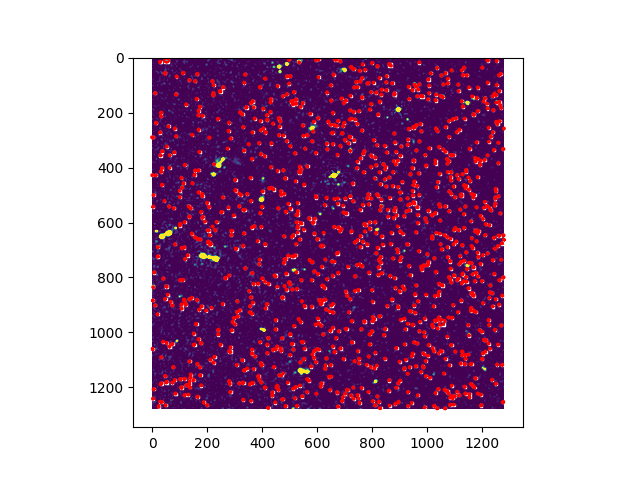

In [154]:
cat = "../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_teste_annotatons.json"
fig = plot_image_catalog(arr,cat, crop_number = 3, bounding_boxes=True, segmentations=True, vmin=1e-9,vmax=1e-4)

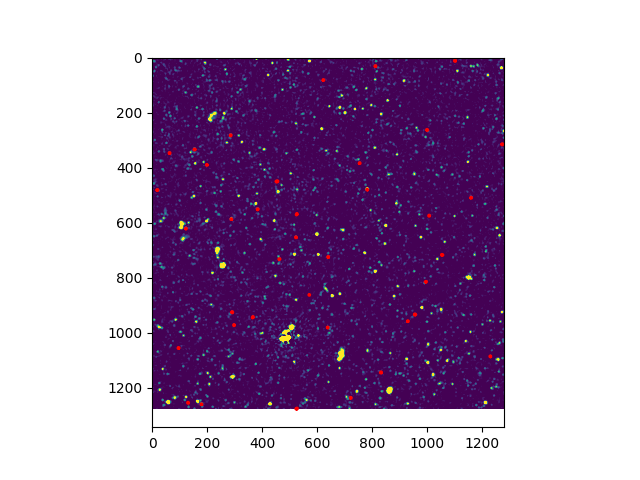

In [45]:
fig = plot_image_catalog(arr,info[1:], crop_number = 1, bounding_boxes=False, segmentations=True, vmin=1e-9,vmax=1e-4)

### make crop catalogs

In [4]:
ff = glob.glob("../data/MGCLS_data/enhanced/*.fits")

#ff=glob.glob("../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor.fits")
for f in ff:
    if os.path.exists(f"{f[:f.rfind('.')]}_annotations.json") or "Abell_548" in f:
        continue
    
    #print(f.split('_', 3),'_'.join(f.split('_', 3)[:3]))
    catalog = glob.glob(f"{'_'.join(f.split('_', 3)[:3])}*.csv")
    i=2
    while len(catalog) == 0:
        catalog = glob.glob(f"{'_'.join(f.split('_', i)[:i])}*.csv")
        i-=1
        if i ==0:
            print(f)
            break
    catalog = catalog[0]
    print(catalog)
    crop_coords = f"{f[:f.rfind('.')]}_large_coords.npy"
    prefix = f[f.rfind('/')+1:f.rfind('.')]
    output = f"{f[:f.rfind('.')]}_annotations.json"
    arglist = ["--image", f, "--catalog", catalog, "--crop_coords",crop_coords,"--crop_prefix",prefix,"--output_file",output,"--category_names","source","--description","MGCLS survey","--annotations_only","True"]
    t = dt.now()
    parser = argparse.ArgumentParser('pyBDSF_to_COCO', parents=[get_args_parser()])
    args = parser.parse_args(arglist)
    try:
        run_main(args)
    except Exception as e:
        print(f"error in run_main for {f}!!")
    print(f)
    print(dt.now()-t)

../data/MGCLS_data/enhanced/Abell_3667_compact_source_catalog.csv


error in run_main for ../data/MGCLS_data/enhanced/Abell_3365A_noFix_pol_I_Farcsec_5pln_cor.fits!!
../data/MGCLS_data/enhanced/Abell_3365A_noFix_pol_I_Farcsec_5pln_cor.fits
0:00:02.330703
../data/MGCLS_data/enhanced/J0658.5-5556†_compact_source_catalog.csv
error in run_main for ../data/MGCLS_data/enhanced/J0658.5-5556_aFix_pol_I_Farcsec_5pln_cor.fits!!
../data/MGCLS_data/enhanced/J0658.5-5556_aFix_pol_I_Farcsec_5pln_cor.fits
0:00:00.023069
../data/MGCLS_data/enhanced/J0416.7-5525_compact_source_catalog.csv


error in run_main for ../data/MGCLS_data/enhanced/J0416.7-5525_aFix_pol_I_Farcsec_5pln_cor.fits!!
../data/MGCLS_data/enhanced/J0416.7-5525_aFix_pol_I_Farcsec_5pln_cor.fits
0:01:53.739382
../data/MGCLS_data/enhanced/J0600.8-5835_compact_source_catalog.csv


../data/MGCLS_data/enhanced/J0600.8-5835_aFix_pol_I_Farcsec_5pln_cor.fits
0:03:23.853500
../data/MGCLS_data/enhanced/J0051.1-4833_compact_source_catalog.csv


../data/MGCLS_data/enhanced/J0051.1-4833_aFix_pol_I_Farcsec_5pln_cor.fits
0:03:31.870999
../data/MGCLS_data/enhanced/J0542.8-4100_compact_source_catalog.csv


KeyboardInterrupt: 

In [ ]:
df = pd.read_csv("../data/MGCLS_data/enhanced/J0317.9-4414_compact_source_catalog.csv")
df.head()

In [ ]:
!python pyBDSF_to_COCO.py --image ../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor.fits \
--catalog ../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_compact_source_catalog.csv \
--crop_coords ../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_large_coords.npy \
--crop_prefix J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_ \
--output_file ../data/MGCLS_data/enhanced/large_crops/J0225.9-4154_aFix_pol_I_Farcsec_5pln_cor_teste_annotatons.json \
--category_names source \
--description "MGCLS survey" \
--dataset_url https://mgcls.sarao.ac.za/

### Abell 548 fixed catalog

In [ ]:
!python pyBDSF_to_COCO.py --image ../data/MGCLS_data/enhanced/Abell_548_aFix_pol_I_Farcsec_5pln_cor.fits \
--catalog ../data/MGCLS_data/enhanced/Abell_548_compact_source_catalog.csv \
--crop_coords ../data/MGCLS_data/enhanced/Abell_548_aFix_pol_I_Farcsec_5pln_cor_large_coords.npy \
--crop_prefix Abell_548_aFix_pol_I_Farcsec_5pln_cor_ \
--output_file ../data/MGCLS_data/enhanced/large_crops/Abell_548_aFix_pol_I_Farcsec_5pln_cor_annotatons.json \
--category_names source \
--description "MGCLS survey" \
--dataset_url https://mgcls.sarao.ac.za/

## MIGHTEE XMM crop catalogs -> COCO

In [264]:
!python pyBDSF_to_COCO.py --image ../data/MIGHTEE/early_science/MIGHTEE_Continuum_Early_Science_XMMLSS_r0p0_circ.fits \
--catalog ../data/MIGHTEE/early_science/MIGHTEE_Continuum_Early_Science_XMMLSS_Level1.txt \
--crop_coords ../data/MIGHTEE/early_science/MIGHTEE_Continuum_Early_Science_XMMLSS_r0p0_circ_crop_coords.npy \
--crop_prefix arrays/adapteq/XMMLSS_r0p0_log10_adapteq_ \
--start_imid 421 \
--start_annid  15745 \
--output_file ../data/MIGHTEE/early_science/xmmlss_crop_coco_annotatons.json \
--description "MIGHTEE XMMLSS field" \
--dataset_url https://www.mighteesurvey.org/data-access \
--category_names source

In [24]:
with open("../data/MIGHTEE/early_science/xmmlss_crop_coco_annotatons.json") as f:
    xcat = json.load(f)

In [67]:
idf = pd.DataFrame(xcat["images"])

In [68]:
idf.describe()

,id,width,height,license
count,914.000000,914.0,914.0,914.0
mean,877.500000,256.0,256.0,1.0
std,263.993371,0.0,0.0,0.0
min,421.000000,256.0,256.0,1.0
25%,649.250000,256.0,256.0,1.0
50%,877.500000,256.0,256.0,1.0
75%,1105.750000,256.0,256.0,1.0
max,1334.000000,256.0,256.0,1.0


In [66]:
adf = pd.DataFrame(xcat["annotations"])
adf.describe()

,id,image_id,category_id,iscrowd,area
count,32376.000000,32376.000000,32376.0,32376.000000,32376.000000
mean,31932.500000,885.664628,1.0,0.062114,85.524771
std,9346.290494,258.501173,0.0,0.241366,118.641299
min,15745.000000,421.000000,1.0,0.000000,9.000000
25%,23838.750000,662.000000,1.0,0.000000,64.000000
50%,31932.500000,892.000000,1.0,0.000000,72.000000
75%,40026.250000,1112.000000,1.0,0.000000,81.000000
max,48120.000000,1334.000000,1.0,1.000000,8836.000000


In [300]:
for i,a in enumerate(xcat["annotations"]):
    a['id'] += 15745

In [301]:
#mdict = {"info":info,"images":image_info,"annotations":annotations,"categories":categories}

with open("../data/MIGHTEE/early_science/xmmlss_crop_coco_annotatons.json", 'w') as f: 
        json.dump(xcat, f)

In [44]:
n = np.random.randint(914)
n

133

In [51]:
im = np.load(f"arrays/MIGHTEE_Continuum_Early_Science_XMMLSS_r0p0_circ_crop_{n}.npy")

In [52]:
np.mean(im), np.min(im), np.max(im)

(3.9234192463504693e-07, -1.8421419714492957e-05, 0.0007204791390505198)

In [53]:
from astropy.visualization import ZScaleInterval
zint = ZScaleInterval()

In [55]:
zim = zint(im)
np.mean(zim), np.min(zim), np.max(zim)

(0.34019919144191396, 0.0, 1.0)

In [62]:
np.save(f"arrays/MIGHTEE_Continuum_Early_Science_XMMLSS_r0p0_zscale_crop_{n}.npy",zim)

In [72]:
421+303

724

IndexError: list index out of range

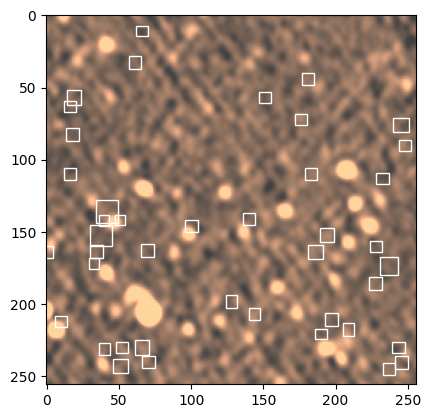

In [71]:
fig = plot_image_catalog(f"arrays/MIGHTEE_Continuum_Early_Science_XMMLSS_r0p0_zscale_crop_{n}.npy", xcat["annotations"], crop_number=724,segmentations = True, alpha = 0.75, cmap=matplotlib.colormaps["copper"])

### combine two catalogs

In [313]:
print(len(ccat['images']), len(ccat['annotations']))
ccat['images'].extend(xcat['images'])
ccat['annotations'].extend(xcat['annotations'])
len(ccat['images']), len(ccat['annotations'])

421 15745


(1335, 48121)

In [314]:
mdict =  {"info":ccat['info'],"images":ccat['images'],"annotations":ccat['annotations'],"categories":ccat['categories']}

In [320]:
with open("../data/MIGHTEE/early_science/mightee_coco_annotations.json") as f:
    mcat = json.load(f)

In [321]:
adf = pd.DataFrame(mcat['annotations'])
adf.describe()

,id,image_id,category_id,iscrowd,area
count,48121.000000,48121.000000,48121.0,48121.000000,48121.000000
mean,24060.000000,664.424763,1.0,0.065605,88.804555
std,13891.480489,386.725706,0.0,0.247594,106.374393
min,0.000000,0.000000,1.0,0.000000,1.000000
25%,12030.000000,304.000000,1.0,0.000000,64.000000
50%,24060.000000,671.000000,1.0,0.000000,72.000000
75%,36090.000000,1001.000000,1.0,0.000000,90.000000
max,48120.000000,1334.000000,1.0,1.000000,8836.000000


In [322]:
len(adf.id), len(set(adf.id))

(48121, 48121)

In [317]:
with open("../data/MIGHTEE/early_science/mightee_coco_annotations.json", 'w') as f: 
        json.dump(mdict, f)

In [134]:
def reset_image_id(ann, id_offset):
    ann["image_id"] = ann["image_id"]+ id_offset
    return ann

def combine_coco(jsondir, output_name, info = None, categories= None):
    """Combine all annotations in one folder into a single COCO dataset. Slow right now."""
    jj = glob.glob(os.path.join(jsondir,"*.json"))
    ims = []
    anns = []
    imid = 0
    for j in jj:
        with open(j) as f:
            dd = json.load(f)

        imlist = [i for i in dd['images']]
        annlist = [reset_image_id(a,imid) for a in dd['annotations']]
        imid += len(imlist)
        
        ims.extend(imlist)
        anns.extend(annlist)

    try:
        info = dd['info']
    except KeyError:
        info = create_info()
    try:
        categories = dd['categories']
    except KeyError:
        categories = create_categories("source")

    idf = pd.DataFrame.from_records(ims).reset_index(drop=True)
    adf = pd.DataFrame.from_records(anns).reset_index(drop=True)
    
    idf["id"] = idf.index.values.tolist()
    adf["id"] = adf.index.values.tolist() #this way they are all unique

    flat_anns = adf.to_dict()
    flat_ims = idf.to_dict()

    mdict = {"info":info,"images":flat_ims,"annotations":flat_anns,"categories":categories}    

    with open(os.path.join(jsondir,output_name), 'w') as f: 
        json.dump(mdict, f)

In [135]:
cdir = "../data/MGCLS_data/enhanced/large_crops/"

In [136]:
combine_coco(cdir, "MGCLS_enhanced_COCO.json")

In [137]:
with open("../data/MGCLS_data/enhanced/large_crops/MGCLS_enhanced_COCO.json") as f:
    j = json.load(f)

In [ ]:
j['info']

{'year': 2023,
 'version': '',
 'description': '',
 'contributer': 'lastufka',
 'url': None,
 'date_created': '2023-05-23T18:31:56.650'}

In [138]:
ii= j["images"]
idf = pd.DataFrame.from_records(ii)
idf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 936 entries, 0 to 935
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   coco_url       936 non-null    object
 1   date_captured  936 non-null    object
 2   file_name      936 non-null    object
 3   flickr_url     936 non-null    object
 4   height         936 non-null    int64 
 5   id             936 non-null    int64 
 6   license        936 non-null    int64 
 7   width          936 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 65.8+ KB


In [139]:
aa= j["annotations"]
adf = pd.DataFrame.from_records(aa)
adf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 702692 entries, 0 to 702691
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   area          702692 non-null  int64 
 1   bbox          702692 non-null  object
 2   category_id   702692 non-null  int64 
 3   id            702692 non-null  int64 
 4   image_id      702692 non-null  int64 
 5   iscrowd       702692 non-null  int64 
 6   segmentation  702692 non-null  object
dtypes: int64(5), object(2)
memory usage: 42.9+ MB


In [140]:
adf.id.nunique(), adf.image_id.nunique()

(702692, 936)

In [133]:
adf.image_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

## re-format segmentations to see if evaluator works

In [272]:
from utils import train_val_split

In [ ]:
train_val_split(full_json, train_dir, val_dir, **kwargs):

In [400]:
with open("../data/MIGHTEE/early_science/mightee_coco_annotations_train0.json") as f:
    tcat = json.load(f)

In [401]:
with open("../data/MIGHTEE/early_science/mightee_coco_annotations_val0.json") as f:
    vcat = json.load(f)

In [402]:
for i,a in enumerate(vcat['annotations']):
    seg = a['segmentation'][0]
    px = [int(x) for x,_ in seg]
    py = [int(y) for _,y in seg]
    poly = [(x , y) for x, y in zip(px, py)]
    poly = [p for x in poly for p in x]
    vcat['annotations'][i]['segmentation'] = [poly]

In [403]:
for i,a in enumerate(tcat['annotations']):
    seg = a['segmentation'][0]
    px = [int(x) for x,_ in seg]
    py = [int(y) for _,y in seg]
    poly = [(x , y) for x, y in zip(px, py)]
    poly = [p for x in poly for p in x]
    tcat['annotations'][i]['segmentation'] = [poly]

In [404]:
with open("../data/MIGHTEE/early_science/mightee_coco_annotations_train.json","w") as f:
    json.dump(tcat,f)
    
with open("../data/MIGHTEE/early_science/mightee_coco_annotations_val.json","w") as f:
    json.dump(vcat,f)

## register COCO dataset with detectron2

In [1]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from map_utils import mapdata_from_fits
import random
from matplotlib.patches import Rectangle
import json

In [324]:
register_coco_instances("mightee_train3", {}, "../data/MIGHTEE/early_science/mightee_coco_annotations_train.json", "../data/MIGHTEE/early_science/train")
register_coco_instances("mightee_val3", {}, "../data/MIGHTEE/early_science/mightee_coco_annotations_val.json", "../data/MIGHTEE/early_science/val")

In [207]:
register_coco_instances("cosmos_train9", {}, "../data/MIGHTEE/early_science/cosmos_crop_coco_annotatons.json", "../data/MIGHTEE/early_science/arrays/adapteq/")
#register_coco_instances("mightee_val", {}, "../data/MIGHTEE/early_science/mightee_coco_annotations_val.json", "../data/MIGHTEE/early_science/val")

In [213]:
cosmos_data = DatasetCatalog.get("cosmos_train9")
cosmos_meta = MetadataCatalog.get("cosmos_train9")

In [216]:
cosmos_data[0]

{'file_name': '../data/MIGHTEE/early_science/arrays/adapteq/../data/MIGHTEE/early_science/arrays/adapteq/COSMOS_r0p0_log10_adapteq_crop_0.npy',
 'height': 256,
 'width': 256,
 'image_id': 0,
 'annotations': [{'iscrowd': 0,
   'bbox': [37, 169, 8, 7],
   'category_id': 0,
   'segmentation': [[[38.50043478371134, 174.2051183979056],
     [37.91256960716106, 173.38776482672938],
     [37.62724955697132, 172.40343867765523],
     [37.70731306243488, 171.46892635976474],
     [37.78737656789838, 170.53441404187424],
     [38.226286798425576, 169.7260143466151],
     [38.927378870253506, 169.22176792362552],
     [39.628470942081435, 168.7175215006364],
     [40.53450379294702, 168.55859783685628],
     [41.44593420393477, 168.77999802457725],
     [42.357364614922574, 169.00139821229868],
     [43.199778330045035, 169.58504590685834],
     [43.787643506595316, 170.40239947803457],
     [44.3755086831456, 171.2197530492108],
     [44.660828733335336, 172.20407919828494],
     [44.58076522787

In [325]:
train_data = DatasetCatalog.get("mightee_train3")
train_meta = MetadataCatalog.get("mightee_train3")

In [8]:
test = np.zeros((256,256))
atest = np.repeat(test[:,:,np.newaxis], 3, axis=2)
atest.shape

(256, 256, 3)

In [4]:
train_meta = MetadataCatalog.get("dataset_train")

In [279]:
with open("../data/MIGHTEE/early_science/mightee_coco_annotations.json") as f:
    sdict = json.load(f)
sdict['images'][0]['file_name']

'arrays/adapteq/COSMOS_r0p0_log10_adapteq_crop_0.npy'

In [280]:
def train_val_split(full_json, train_dir, val_dir, json_only=False, path_prefix = '', **kwargs):
    """do sklearn train_test_split, move images into the correct folders, and split the json"""
    with open(full_json) as f: 
        sdict = json.load(f)
    from sklearn.model_selection import train_test_split
    import shutil

    idf = pd.DataFrame(sdict["images"])
    adf = pd.DataFrame(sdict["annotations"])
    X_train,X_val = train_test_split(idf.id.values, **kwargs)

    trainims, trainanns = [],[]
    valims, valanns = [],[]
    akeys = ['id','image_id','iscrowd','category_id']
    ikeys = ['id','width','height']
    #move images
    for x in X_train:
        imfile = idf.where(idf.id == x).dropna(how='all')
        for k in ikeys:
            imfile[k] = imfile[k].astype(int)
        if not json_only:
            shutil.move(f"{path_prefix}{imfile.file_name.values[0]}", train_dir)
        #adjust imfile name
        imfile['file_name'] = [f[f.rfind("/")+1:] for f in imfile['file_name']]
        trainims.extend(imfile.to_dict(orient='records'))
        anns = adf.where(adf.image_id == x).dropna(how='all')
        for k in akeys:
            anns[k] = anns[k].astype(int)
        trainanns.extend(anns.to_dict(orient='records'))
        

    for x in X_val:
        imfile = idf.where(idf.id == x).dropna(how='all')
        for k in ikeys:
            imfile[k] = imfile[k].astype(int)
        if not json_only:
            shutil.move(f"{path_prefix}{imfile.file_name.values[0]}", val_dir)
        imfile['file_name'] = [f[f.rfind("/")+1:] for f in imfile['file_name']]
        valims.extend(imfile.to_dict(orient='records'))
        anns = adf.where(adf.image_id == x).dropna(how='all')
        for k in akeys:
            anns[k] = anns[k].astype(int)
        valanns.extend(anns.to_dict(orient='records'))


    #split JSON
    traininfo = sdict['info'].copy()
    valinfo = sdict['info'].copy()
    traininfo['description'] += " train"
    valinfo['description'] += " val"
    train_json =  {"info":traininfo,"images":trainims,"annotations":trainanns,"categories":sdict['categories']}
    val_json =  {"info":valinfo,"images":valims,"annotations":valanns,"categories":sdict['categories']}
    
    #return train_json, val_json
    
    with open(f"{full_json[:full_json.rfind('.')]}_train.json",'w') as f:
         json.dump(train_json,f)
         
    with open(f"{full_json[:full_json.rfind('.')]}_val.json",'w') as f:
         json.dump(val_json,f)

In [323]:
train_val_split("../data/MIGHTEE/early_science/mightee_coco_annotations.json", '../data/MIGHTEE/early_science/train','../data/MIGHTEE/early_science/val', path_prefix="../data/MIGHTEE/early_science/",test_size=0.2)

In [17]:
ff = glob.glob("../data/MIGHTEE/early_science/train/*.npy")
for f in ff:
    if np.load(f).shape != (256,256):
        print(f)

In [88]:
tt['images'][:5]

[[{'id': 365,
   'file_name': '../data/MIGHTEE/early_science/arrays/adapteq/COSMOS_r0p0_log10_adapteq_crop_365.npy',
   'width': 256,
   'height': 256,
   'date_captured': '2023-04-28T12:24:54.432',
   'license': 1.0,
   'coco_url': '',
   'flickr_url': ''}],
 [{'id': 123,
   'file_name': '../data/MIGHTEE/early_science/arrays/adapteq/COSMOS_r0p0_log10_adapteq_crop_123.npy',
   'width': 256,
   'height': 256,
   'date_captured': '2023-04-28T12:24:42.980',
   'license': 1.0,
   'coco_url': '',
   'flickr_url': ''}],
 [{'id': 770,
   'file_name': '../data/MIGHTEE/early_science/arrays/adapteq/XMMLSS_r0p0_log10_adapteq_crop_349.npy',
   'width': 256,
   'height': 256,
   'date_captured': '2023-04-28T12:30:56.261',
   'license': 1.0,
   'coco_url': '',
   'flickr_url': ''}],
 [{'id': 823,
   'file_name': '../data/MIGHTEE/early_science/arrays/adapteq/XMMLSS_r0p0_log10_adapteq_crop_402.npy',
   'width': 256,
   'height': 256,
   'date_captured': '2023-04-28T12:30:58.905',
   'license': 1.0,
  

In [53]:
import shutil
shutil.move("../data/MIGHTEE/early_science/mightee_coco_annotatons.json","../data/MIGHTEE/")

'../data/MIGHTEE/mightee_coco_annotatons.json'

In [56]:
xx = np.load("../data/MIGHTEE/early_science/XMMLSS_r0p0_log10_adapteq.npy")
xx.shape

(4706, 9203)

In [5]:
wcs, dat = mapdata_from_fits("../data/MIGHTEE/early_science/MIGHTEE_Continuum_Early_Science_COSMOS_r0p0.app.restored.circ.fits")

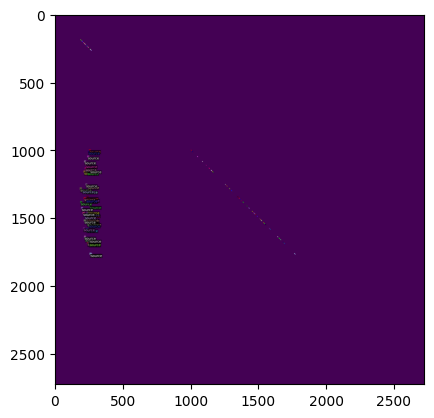

In [10]:
d = random.sample(train_data, 1)[0]
    #img = cl[d["image_id"]]
fig, ax =plt.subplots()
visualizer = Visualizer(dat, metadata=train_meta, scale=0.5)
out = visualizer.draw_dataset_dict(d)
ax.imshow(out.get_image(), vmin = 1e-9, vmax = 1e-3)
#ax.set_xlim(300,500)
#ax.set_ylim(1000,1500)

In [6]:
train_crop_meta

namespace(name='dataset_crop_train',
          json_file='../data/MIGHTEE/early_science/cosmos_crop_coco_annotatons.json',
          image_root='',
          evaluator_type='coco',
          thing_classes=['source'],
          thing_dataset_id_to_contiguous_id={1: 0})

In [4]:
train_crop_data[1]

{'file_name': '../data/MIGHTEE/early_science/crop_1.npy',
 'height': 256,
 'width': 256,
 'image_id': 1,
 'annotations': [{'iscrowd': 0,
   'bbox': [429, 2317, 10, 10],
   'category_id': 0,
   'segmentation': [[30.794706619331237,
     30.431442318734753,
     30.439531781166295,
     30.817193396421203,
     31.194855011676168,
     31.911254381674837,
     32.808612860552614,
     33.70597133943039,
     34.711023582126586,
     35.60241849801105,
     36.493813413895566,
     37.19877255641126,
     37.5620368570078,
     37.92530115760428,
     37.91721169517274,
     37.53955007991783,
     37.161888464662866,
     36.4454890946642,
     35.54813061578642,
     34.65077213690864,
     33.64571989421245,
     32.754324978327986,
     31.862930062443468,
     31.157970919927777,
     30.794706619331237,
     30.794706619331237],
    [122.80485340610994,
     121.44204263211304,
     120.03983218244412,
     118.90704263293128,
     117.77425308341844,
     117.00337168322676,
     1

In [58]:
1068+267

1335

In [29]:
np.nanmean(dat[1000:1500,0:500])

/tmp/ipykernel_1068/3005315989.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(dat[1000:1500,0:500])


nan

(2700.0, 3000.0)

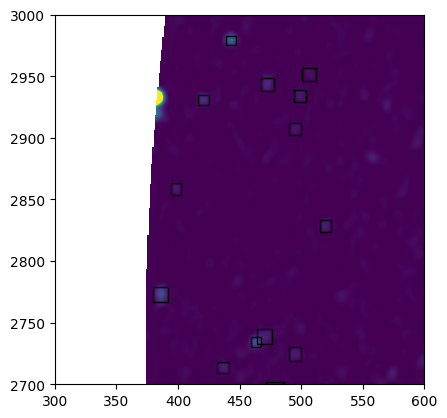

In [18]:
fig, ax = plt.subplots()
ax.imshow(dat, vmin = 1e-9, vmax = 1e-3)
for a in random.sample(train_data,1)[0]["annotations"]:
    rect = Rectangle(a["bbox"][:2],a["bbox"][2],a["bbox"][3], fill=None)
    ax.add_artist(rect)
ax.set_xlim(300,600)
ax.set_ylim(2700,3000)

In [2]:
## visualize some detectron results

In [3]:
import json

In [4]:
pwd

'/home/glados/unix-Documents/AstroSignals/pyBDSF_to_COCO'

In [5]:
with open("../data/MIGHTEE/early_science/mightee_coco_annotations_val.json") as f:
    valj = json.load(f) 

In [9]:
len(valj['images']), len(valj['annotations'])

(267, 9393)

In [55]:
train_data = DatasetCatalog.get("mightee_train")
train_metadata = MetadataCatalog.get("mightee_train")

In [333]:
#register_coco_instances("cosmos_train9", {}, "../data/MIGHTEE/early_science/cosmos_crop_coco_annotatons.json", "../data/MIGHTEE/early_science/arrays/adapteq/")
register_coco_instances("mightee_val4", {}, "../data/MIGHTEE/early_science/mightee_coco_annotations_val.json", "../data/MIGHTEE/early_science/val")

In [334]:
val_data = DatasetCatalog.get("mightee_val4")
val_metadata = MetadataCatalog.get("mightee_val4")

In [20]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("mightee_train",)
cfg.DATASETS.TEST = ("mightee_val",)
cfg.DATALOADER.NUM_WORKERS = 0
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning n_trainrate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

cfg.OUTPUT_DIR = "/home/glados/unix-Documents/AstroSignals/data/MIGHTEE/early_science/train"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

R-50.pkl: 102MB [00:12, 8.13MB/s]                                                                              
Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mas

### plot

In [247]:
d = cosmos_data[0]
visualizer = Visualizer(img[:, :, 0], metadata=cosmos_meta)
masks = [x["segmentation"] for x in d['annotations']]
print(masks[0])
masks = visualizer._convert_masks(masks)
areas = np.asarray([x.area() for x in masks])
sorted_idxs = np.argsort(-areas).tolist()
masks = [masks[idx] for idx in sorted_idxs] if masks is not None else None

[[[38.50043478371134, 174.2051183979056], [37.91256960716106, 173.38776482672938], [37.62724955697132, 172.40343867765523], [37.70731306243488, 171.46892635976474], [37.78737656789838, 170.53441404187424], [38.226286798425576, 169.7260143466151], [38.927378870253506, 169.22176792362552], [39.628470942081435, 168.7175215006364], [40.53450379294702, 168.55859783685628], [41.44593420393477, 168.77999802457725], [42.357364614922574, 169.00139821229868], [43.199778330045035, 169.58504590685834], [43.787643506595316, 170.40239947803457], [44.3755086831456, 171.2197530492108], [44.660828733335336, 172.20407919828494], [44.58076522787178, 173.13859151617544], [44.50070172240828, 174.07310383406593], [44.06179149188108, 174.88150352932507], [43.36069942005315, 175.38574995231465], [42.65960734822522, 175.88999637530378], [41.75357449735964, 176.0489200390839], [40.84214408637189, 175.82751985136292], [39.930713675384084, 175.6061196636415], [39.08829996026162, 175.02247196908183], [38.500434783

In [261]:
d['file_name']

'../data/MIGHTEE/early_science/arrays/adapteq/../data/MIGHTEE/early_science/arrays/adapteq/COSMOS_r0p0_log10_adapteq_crop_0.npy'

In [245]:
d['annotations'][0]['segmentation']

[[[38.50043478371134, 174.2051183979056],
  [37.91256960716106, 173.38776482672938],
  [37.62724955697132, 172.40343867765523],
  [37.70731306243488, 171.46892635976474],
  [37.78737656789838, 170.53441404187424],
  [38.226286798425576, 169.7260143466151],
  [38.927378870253506, 169.22176792362552],
  [39.628470942081435, 168.7175215006364],
  [40.53450379294702, 168.55859783685628],
  [41.44593420393477, 168.77999802457725],
  [42.357364614922574, 169.00139821229868],
  [43.199778330045035, 169.58504590685834],
  [43.787643506595316, 170.40239947803457],
  [44.3755086831456, 171.2197530492108],
  [44.660828733335336, 172.20407919828494],
  [44.58076522787178, 173.13859151617544],
  [44.50070172240828, 174.07310383406593],
  [44.06179149188108, 174.88150352932507],
  [43.36069942005315, 175.38574995231465],
  [42.65960734822522, 175.88999637530378],
  [41.75357449735964, 176.0489200390839],
  [40.84214408637189, 175.82751985136292],
  [39.930713675384084, 175.6061196636415],
  [39.0882

In [223]:
from matplotlib.patches import Polygon

In [256]:
masks[4].polygons

[array([ 38.50043478, 174.2051184 ,  37.91256961, 173.38776483,
         37.62724956, 172.40343868,  37.70731306, 171.46892636,
         37.78737657, 170.53441404,  38.2262868 , 169.72601435,
         38.92737887, 169.22176792,  39.62847094, 168.7175215 ,
         40.53450379, 168.55859784,  41.4459342 , 168.77999802,
         42.35736461, 169.00139821,  43.19977833, 169.58504591,
         43.78764351, 170.40239948,  44.37550868, 171.21975305,
         44.66082873, 172.2040792 ,  44.58076523, 173.13859152,
         44.50070172, 174.07310383,  44.06179149, 174.88150353,
         43.36069942, 175.38574995,  42.65960735, 175.88999638,
         41.7535745 , 176.04892004,  40.84214409, 175.82751985,
         39.93071368, 175.60611966,  39.08829996, 175.02247197,
         38.50043478, 174.2051184 ,  38.50043478, 174.2051184 ])]

In [116]:
m2 = []
for x,y in zip(*mm):
    m2.append(x)
    m2.append(y)
len(m2)

52

In [117]:
m2

[38.82827847569024,
 161.066821631955,
 38.79122126737184,
 162.65051652493503,
 38.32471200875352,
 164.15947634505847,
 37.531493949187734,
 165.26137020671285,
 36.738275889621946,
 166.3632640683668,
 35.68311177021042,
 166.96812721845254,
 34.59838924077212,
 166.94274556891924,
 33.51366671133337,
 166.9173639193864,
 32.48794856175073,
 166.26380976949395,
 31.74713730877238,
 165.12602083483443,
 31.00632605579449,
 163.98823190017492,
 30.61090565689392,
 162.45910360756625,
 30.64796286521232,
 160.87540871458577,
 30.685020073530723,
 159.29171382160575,
 31.15152933214904,
 157.78275400148232,
 31.944747391714827,
 156.68086013982793,
 32.737965451280616,
 155.578966278174,
 33.793129570692145,
 154.97410312808825,
 34.87785210013044,
 154.99948477762155,
 35.96257462956919,
 155.0248664271544,
 36.988292779151834,
 155.67842057704684,
 37.72910403213018,
 156.81620951170635,
 38.46991528510807,
 157.95399844636586,
 38.86533568400864,
 159.48312673897453,
 38.828278475690

In [257]:
segment = np.array(masks[4].polygons).reshape(-1, 2)
segment

array([[ 38.50043478, 174.2051184 ],
       [ 37.91256961, 173.38776483],
       [ 37.62724956, 172.40343868],
       [ 37.70731306, 171.46892636],
       [ 37.78737657, 170.53441404],
       [ 38.2262868 , 169.72601435],
       [ 38.92737887, 169.22176792],
       [ 39.62847094, 168.7175215 ],
       [ 40.53450379, 168.55859784],
       [ 41.4459342 , 168.77999802],
       [ 42.35736461, 169.00139821],
       [ 43.19977833, 169.58504591],
       [ 43.78764351, 170.40239948],
       [ 44.37550868, 171.21975305],
       [ 44.66082873, 172.2040792 ],
       [ 44.58076523, 173.13859152],
       [ 44.50070172, 174.07310383],
       [ 44.06179149, 174.88150353],
       [ 43.36069942, 175.38574995],
       [ 42.65960735, 175.88999638],
       [ 41.7535745 , 176.04892004],
       [ 40.84214409, 175.82751985],
       [ 39.93071368, 175.60611966],
       [ 39.08829996, 175.02247197],
       [ 38.50043478, 174.2051184 ],
       [ 38.50043478, 174.2051184 ]])

In [258]:
polygon = Polygon(
            segment,
            fill=True,
            facecolor='r',
            edgecolor='k',
           # linewidth=max(self._default_font_size // 15 * self.output.scale, 1),
        )

In [259]:
del fig
del ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


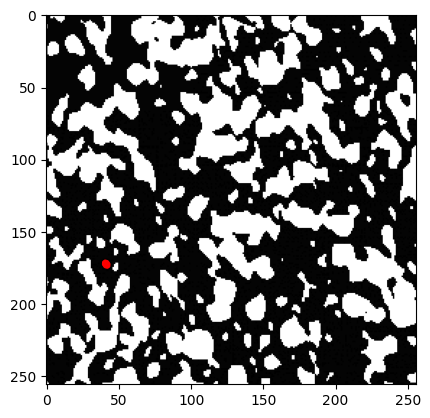

In [260]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.add_patch(polygon)

In [165]:
ls ../data/MIGHTEE/early_science/arrays/adapteq/

'/home/glados/unix-Documents/AstroSignals/pyBDSF_to_COCO'

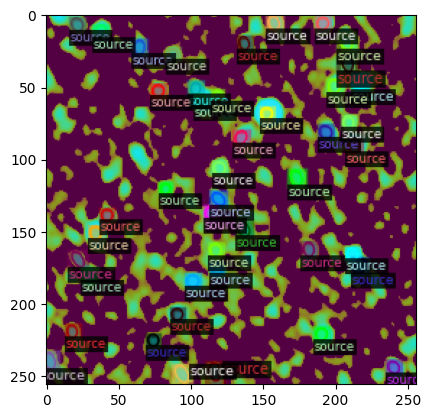

In [327]:
d = random.sample(train_data,1)[0]
im = np.load(d['file_name'])*255
img = np.repeat(im[:,:,np.newaxis], 3, axis=2)
visualizer = Visualizer(img[:, :, 0], metadata=train_metadata)
out = visualizer.draw_dataset_dict(d)
plt.imshow(out.get_image()[:, :, ::-1])

In [405]:
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("mightee_val4", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "mightee_val4")

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)

../data/MIGHTEE/early_science/val/COSMOS_r0p0_log10_adapteq_crop_250.npy


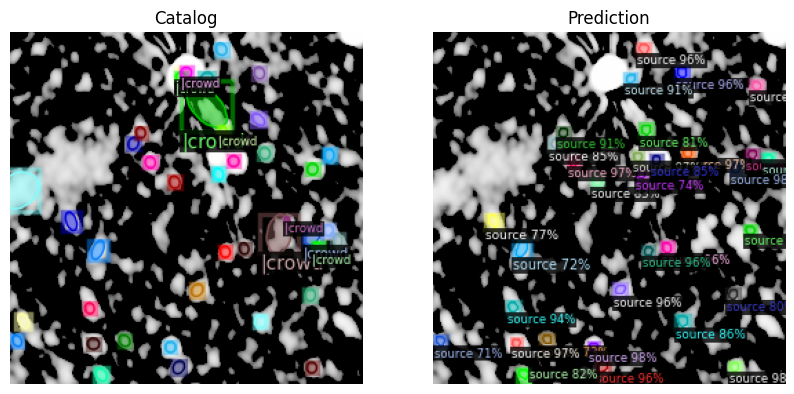

In [430]:
from detectron2.utils.visualizer import ColorMode
#dataset_dicts = #get_balloon_dicts("balloon/val")
for d in random.sample(val_data, 1):
    print(d['file_name'])
    fig,ax = plt.subplots(1,2, figsize = (10,6))
    #im = cv2.imread(d["file_name"])
    im = np.load(d["file_name"])*255
    new_arr = np.repeat(im[:,:,np.newaxis], 3, axis=2)
    outputs = predictor(new_arr)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(new_arr,
                   metadata=val_metadata, 
                   #scale=0.5, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    val_metadata2 = val_metadata.__dict__.copy()
    val_metadata2['thing_classes'] = ['']
    v2 = Visualizer(new_arr, metadata = val_metadata2)
    out2 = v2.draw_dataset_dict(d)
    
    ax[0].imshow(out2.get_image()[:, :, ::-1])
    ax[0].set_title("Catalog")
    ax[1].imshow(out.get_image()[:, :, ::-1])
    ax[1].set_title("Prediction")
    for a in ax:
        a.axis('off')

In [425]:
val_metadata.__dict__

{'name': 'mightee_val4',
 'json_file': '../data/MIGHTEE/early_science/mightee_coco_annotations_val.json',
 'image_root': '../data/MIGHTEE/early_science/val',
 'evaluator_type': 'coco',
 'thing_classes': ['source'],
 'thing_dataset_id_to_contiguous_id': {1: 0}}

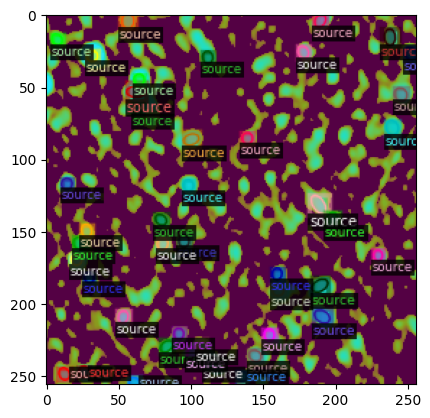

In [407]:
#d = random.sample(train_data,1)[0]
#im = np.load(d['file_name'])*255
#img = np.repeat(im[:,:,np.newaxis], 3, axis=2)
visualizer = Visualizer(new_arr[:, :, 0], metadata=val_metadata)
out = visualizer.draw_dataset_dict(d)
plt.imshow(out.get_image()[:, :, ::-1])

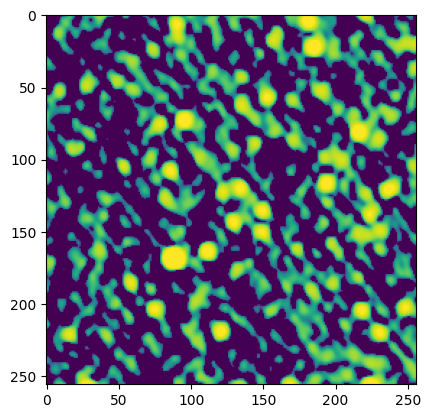

In [348]:
plt.imshow(np.load(d['file_name']))

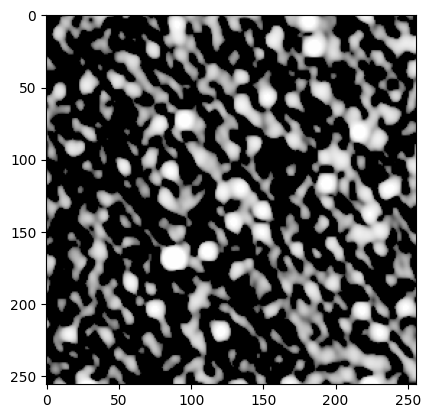

In [349]:
plt.imshow(new_arr[:,:,::-1])

In [353]:
outputs["instances"].to("cpu").scores.numpy().shape[0] == 0

True

In [340]:
for i in range(256):
    d = val_data[i]
    im = np.load(d["file_name"])
    new_arr = np.repeat(im[:,:,np.newaxis], 3, axis=2)
    #print(im.shape)
    outputs = predictor(new_arr)
    if outputs["instances"].to("cpu").scores.numpy().shape[0] != 0:
        print(i)
        break